In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import re
import matplotlib.pyplot as plt
import multiprocessing as mp
import math
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### **Visualizing  the Dataset**

In [2]:
# load edges (or links)
with open("/content/facebook_combined.txt") as f:
    fb_links = f.read().splitlines() 
len(fb_links)

88234

In [3]:
# capture nodes in 2 separate lists
n1 = []
n2 = []

for i in fb_links:
  n1.append(i.split(' ')[0])
  n2.append(i.split(' ')[1])

fb_df = pd.DataFrame({'node_1': n1, 'node_2': n2})

In [7]:
fb_df.head()

,node_1,node_2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


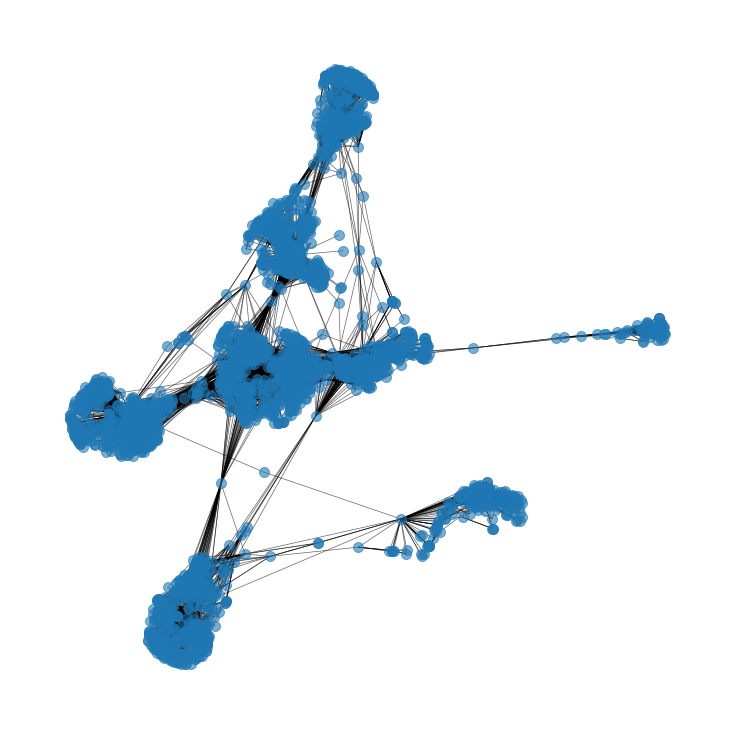

In [4]:
# Visualize the dataset (Present time graph)


G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=False, node_size = 100, alpha = 0.6, width = 0.7)
plt.show()

In [15]:
G.number_of_nodes()

4039

### **Creating the Dataset**

In [5]:
#Find unique nodes in the dataset

nl = n1 + n2
nl = list(dict.fromkeys(nl))
adj_G = nx.to_numpy_matrix(G, nodelist = nl)

In [6]:
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in range(adj_G.shape[0]):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([nl[i],nl[j]])

  offset = offset + 1

In [7]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})
data['link'] = 0

In [8]:
initial_node_count = len(G.nodes)
fb_df_temp = fb_df.copy()
omissible_links_index = []

for i in fb_df.index.values:
  if(i%5000==0):
    print(i)
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000


In [15]:
len(omissible_links_index)

84196

In [16]:
# create dataframe of removable edges

fb_df_ghost = fb_df.loc[omissible_links_index]
fb_df_ghost['link'] = 1
data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [17]:
data['link'].value_counts()

0    1390561
1     168392
Name: link, dtype: int64

In [18]:
data.head()

,node_1,node_2,link
0,0,348,0
1,0,349,0
2,0,350,0
3,0,351,0
4,0,352,0


In [19]:
# drop removable edges

fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [20]:
fb_df_partial.head()

,node_1,node_2
10,0,11
11,0,12
14,0,15
17,0,18
36,0,37


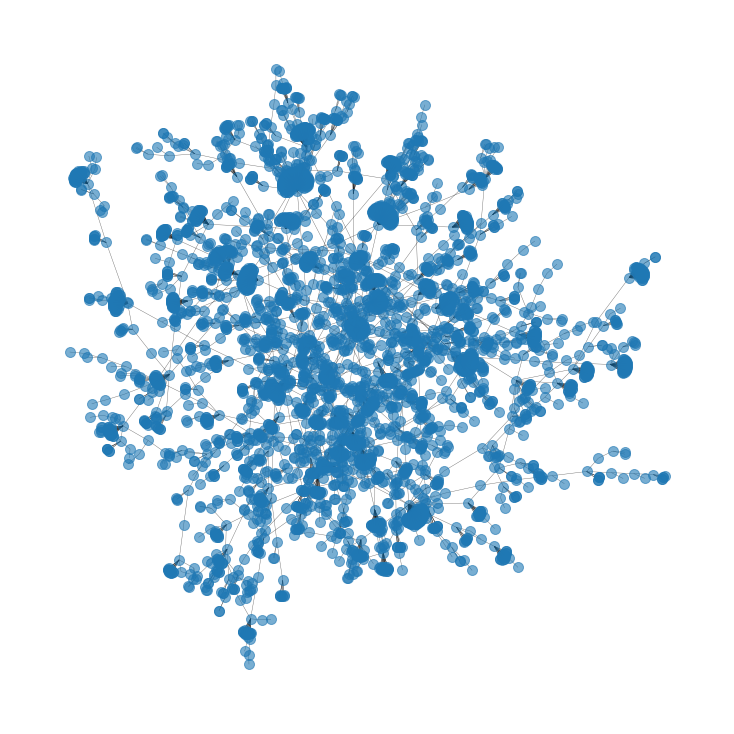

In [21]:
# Visualizing dataset after removing edges

plt.figure(figsize=(10,10))
nx.draw(G_data, with_labels=False, node_size = 100, alpha = 0.6, width = 0.4)
plt.show()

### **Feature Engineering**

In [8]:
data1=pd.read_csv("/content/facebook.csv")


In [9]:
data=data1
data.head()

,Unnamed: 0,node_1,node_2,link
0,0,0,348,0
1,1,0,349,0
2,2,0,350,0
3,3,0,351,0
4,4,0,352,0


In [25]:
data.shape

(1558953, 3)

Jaccard_coefficient

In [22]:
def JaccardCoefficent(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors)) / float(len(u_neighbors.union(v_neighbors)))

In [26]:
Jaccard=[]
for i in range(0,1558953):
  Jaccard.append(JaccardCoefficent(data.node_1[i],data.node_2[i],G))

In [27]:
data['JaccardCoefficent']= Jaccard
data.head()

,node_1,node_2,link,JaccardCoefficent
0,0,348,0,0.006993
1,0,349,0,0.000000
2,0,350,0,0.000000
3,0,351,0,0.002849
4,0,352,0,0.000000


Preferential_attachment

In [28]:
def PreferentialAttachment(u, v, g):
    return len(list(g.neighbors(u)))*len(list(g.neighbors(v)))

In [29]:
preferntial=[]
for i in range(0,1558953):
  preferntial.append(PreferentialAttachment(data.node_1[i],data.node_2[i],G))

In [30]:
data['preferntial_attachment']=preferntial
data.head()

,node_1,node_2,link,JaccardCoefficent,preferntial_attachment
0,0,348,0,0.006993,79463
1,0,349,0,0.000000,1735
2,0,350,0,0.000000,7287
3,0,351,0,0.002849,1735
4,0,352,0,0.000000,7981


Adamic_adar

In [31]:
def AdamicAdar(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    aa = 0
    for i in u_neighbors.intersection(v_neighbors):
      if(math.log(len(list(g.neighbors(i)))) != 0):
        aa += 1 / math.log(len(list(g.neighbors(i))))
    return aa

In [32]:
Adamic=[]
for i in range(0,1558953):
  Adamic.append(AdamicAdar(data.node_1[i],data.node_2[i],G))

In [33]:
data['AdamicAdar']=Adamic
data.head()

,node_1,node_2,link,JaccardCoefficent,preferntial_attachment,AdamicAdar
0,0,348,0,0.006993,79463,1.570042
1,0,349,0,0.000000,1735,0.000000
2,0,350,0,0.000000,7287,0.000000
3,0,351,0,0.002849,1735,0.402430
4,0,352,0,0.000000,7981,0.000000


Common Neighbors

In [34]:
def CommonNeighbors(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors))

In [35]:
Common=[]
for i in range(0,1558953):
  Common.append(CommonNeighbors(data.node_1[i],data.node_2[i],G))

In [36]:
data['CommonNeighbors']=Common
data.head()

,node_1,node_2,link,JaccardCoefficent,preferntial_attachment,AdamicAdar,CommonNeighbors
0,0,348,0,0.006993,79463,1.570042,4
1,0,349,0,0.000000,1735,0.000000,0
2,0,350,0,0.000000,7287,0.000000,0
3,0,351,0,0.002849,1735,0.402430,1
4,0,352,0,0.000000,7981,0.000000,0


Resource Allocation

In [37]:
def ResourceAllocation(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    ra = 0
    for i in u_neighbors.intersection(v_neighbors):
        ra += 1 / (len(list(g.neighbors(i))))
    return ra

In [38]:
Resource=[]
for i in range(0,1558953):
  Resource.append(ResourceAllocation(data.node_1[i],data.node_2[i],G))

In [39]:
data['ResourceAllocation']=Resource
data.head()

,node_1,node_2,link,JaccardCoefficent,preferntial_attachment,AdamicAdar,CommonNeighbors,ResourceAllocation
0,0,348,0,0.006993,79463,1.570042,4,0.367624
1,0,349,0,0.000000,1735,0.000000,0,0.000000
2,0,350,0,0.000000,7287,0.000000,0,0.000000
3,0,351,0,0.002849,1735,0.402430,1,0.083333
4,0,352,0,0.000000,7981,0.000000,0,0.000000


In [40]:
data.shape

(1558953, 8)

In [42]:
data.to_csv('Final_FB_Dataset.csv')

### **Model Training**

In [43]:
data_new=data.drop(['link'],axis=1)
data_new.head()

,node_1,node_2,JaccardCoefficent,preferntial_attachment,AdamicAdar,CommonNeighbors,ResourceAllocation
0,0,348,0.006993,79463,1.570042,4,0.367624
1,0,349,0.000000,1735,0.000000,0,0.000000
2,0,350,0.000000,7287,0.000000,0,0.000000
3,0,351,0.002849,1735,0.402430,1,0.083333
4,0,352,0.000000,7981,0.000000,0,0.000000


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data_new), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [ ]:
x_train.shape, y_train.shape, x_test.shape

((14350, 3), (14350,), (6151, 3))

In [ ]:
x_train

array([['361', '39', 0.18181818181818182, 42, 0.6563691994070403],
       ['49', '550', 0.0, 126, 0.0],
       ['557', '350', 0.07407407407407407, 120, 0.5455414543640047],
       ...,
       ['161', '252', 0.0, 8, 0.0],
       ['558', '484', 0.0, 39, 0.0],
       ['89', '133', 0.0, 86, 0.0]], dtype=object)

Logistic Regression 

In [56]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight='balanced')

In [ ]:
l=lr.predict(x_test)
print(accuracy_score(l, y_test))
score=lr.score(x_test,y_test)
cm=metrics.confusion_matrix(y_test, l)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

SVM

In [ ]:
clf1 = svm.SVC()
clf1.fit(x_train, y_train)
print ("+++++++++ Finishing training the SVM classifier ++++++++++++")
result1 = clf1.predict(x_test)
print ("SVM accuracy:", accuracy_score(y_test, result1))

score=clf1.score(x_test,y_test)
cm=metrics.confusion_matrix(y_test, result1)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

ANN

In [ ]:
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(15,9), random_state=1)
clf.fit(x_train, y_train)
print ("+++++++++ Finishing training the ANN classifier ++++++++++++")
result = clf.predict(x_test)
print ("ANN accuracy:", accuracy_score(y_test, result))

In [ ]:
score=clf.score(x_test,y_test)
cm=metrics.confusion_matrix(y_test, result)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### **Comparision of Models**

In [ ]:
from sklearn.model_selection import cross_val_score
logistic = cross_val_score(lr, x_test, y_test, cv=5)
svm = cross_val_score(clf1, x_test, y_test, cv=5)
ann = cross_val_score(clf, x_test, y_test, cv=5)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


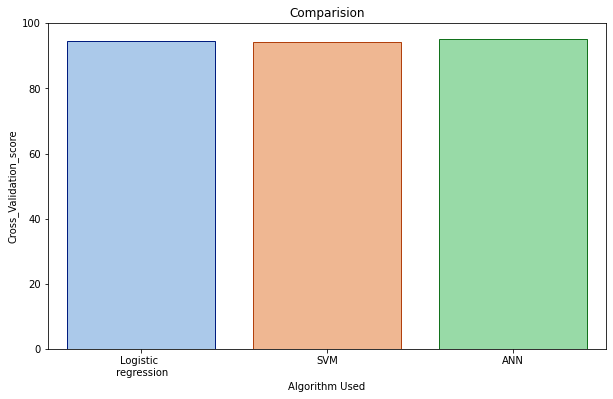

<Figure size 432x288 with 0 Axes>

In [ ]:
data = [['Logistic \n regression', round(logistic.mean()*100,2)], ['SVM', round(svm.mean()*100,2)], ['ANN', round(ann.mean()*100,2)]]
table = pd.DataFrame(data, columns=['Algorithm Used', 'Cross_Validation_score'])
plt.subplots(figsize=(10,6))
sns.barplot(x="Algorithm Used", y="Cross_Validation_score", data = table, palette='pastel', edgecolor=sns.color_palette('dark',7))
plt.title('Comparision')
plt.show()
plt.savefig('Comparison_test')

###**Building Up a Neural Network (Using PyTorch)**

In [61]:
data_new1=data_new.drop(['node_1'],axis=1)
data_new1=data_new1.drop(['node_2'],axis=1)
data_new1.head()

,JaccardCoefficent,preferntial_attachment,AdamicAdar,CommonNeighbors,ResourceAllocation
0,0.000000,30,0.000000,0,0.000000
1,0.000000,102,0.000000,0,0.000000
2,0.000000,6,0.000000,0,0.000000
3,0.000000,30,0.000000,0,0.000000
4,0.019231,282,0.303413,1,0.037037


In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
X = torch.Tensor(data_new.values.astype(np.float))
y = torch.Tensor(data['link'].values.astype(np.float))

x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                test_size = 0.3, 
                                                random_state = 35)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [60]:
x_test.shape

torch.Size([467686, 7])

In [61]:
import torch.nn as nn                       #Building the neural network
class Net(nn.Module):
    def __init__(self,input,H,output):
        super(Net,self).__init__()
        self.linear1=nn.Linear(input,H)
        self.linear2=nn.Linear(H,248)
        self.linear3=nn.Linear(248,output)
 
        
    def forward(self,x):
        x=torch.sigmoid(self.linear1(x))  
        x=torch.sigmoid(self.linear2(x))  
        x=self.linear3(x)
        return x

In [62]:
clf=Net(7,100,2)
print(clf.parameters)

<bound method Module.parameters of Net(
  (linear1): Linear(in_features=7, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=248, bias=True)
  (linear3): Linear(in_features=248, out_features=2, bias=True)
)>


In [63]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(clf.parameters(), lr=0.1)

In [64]:
y_train=y_train.type(torch.LongTensor)

In [51]:
y_train.shape

torch.Size([1091267])

In [68]:
loss_list=[]
for t in range(800):
    y_pred = clf(x_train)                       #Training the model 
    loss = criterion(y_pred, y_train)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if(t%50==0):
      print(t)




0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750


In [69]:
with torch.no_grad():                 #Testing the model
    p=[]                                                
    o=clf(x_test)
    print(o)
    predictions = torch.max(o, 1)
   

tensor([[ 2.0911, -2.2401],
        [-0.5258,  0.3395],
        [ 2.0911, -2.2401],
        ...,
        [-0.5258,  0.3395],
        [ 2.0911, -2.2401],
        [ 2.0911, -2.2401]])


In [70]:
score=accuracy_score(predictions[1],y_test)
print(score)

0.9417921425913968


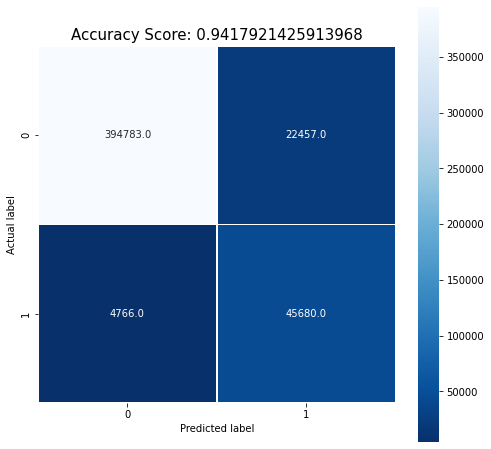

In [71]:

cm=metrics.confusion_matrix(y_test, predictions[1])
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
step = np.linspace(0,800,800)
plt.plot(step,np.array(loss_list))